# Overview

## Motivation
    Airbnb has been disrupting hospitality industry for a while. It boasts rich population of data from every major city in the world. As an avid traveller, I want to see how the the Airbnb listings are like in Paris.
    
## Dataset
    The dataset consists of the Airbnb listings in Paris, with the listing description, host info, numbers of reviews, average scores, and property info (44758, 10). I will be looking at this dataset from different angles using machine learning tools such as clustering and NLP. 
    - Data Source: http://insideairbnb.com/get-the-data.html
    
## Goal
    My goal is to see if there's any distinction between the superhosts and non-superhosts. First, I need to get to know the general population. Then, I will like to know the keywords that can help the hosts to get more bookings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

# Data Exploration

## from bird's eye view
- Let's take a look at the dataset.

In [212]:
df=pd.read_csv('listings.csv', usecols=['id', 'name', 'description', 'host_is_superhost',  
            'number_of_reviews', 'neighbourhood', 'property_type', 'room_type', 
            'review_scores_rating', 'reviews_per_month'])

df=df.dropna()

In [213]:
df.shape

(44758, 10)

In [214]:
# this is how the dataset looks like.
df.head(2)

,id,name,description,host_is_superhost,neighbourhood,property_type,room_type,number_of_reviews,review_scores_rating,reviews_per_month
0,3109,zen and calm,I bedroom appartment in Paris 14 Good restaura...,f,Alésia,Apartment,Entire home/apt,8,100.0,0.28
1,5396,Explore the heart of old Paris,"Cozy, well-appointed and graciously designed s...",f,IV Arrondissement,Apartment,Entire home/apt,173,91.0,1.44


In [215]:
df[df.host_is_superhost=='t'].shape

(6713, 10)

The superhost is about 15% of the entire population, making this dataset imbalanced. 

In [216]:
df.dtypes

id                        int64
name                     object
description              object
host_is_superhost        object
neighbourhood            object
property_type            object
room_type                object
number_of_reviews         int64
review_scores_rating    float64
reviews_per_month       float64
dtype: object

### Data Visualization

In [217]:
df.host_is_superhost=(df.host_is_superhost=='t').astype(int)

In [218]:
df.groupby(by='host_is_superhost').count()

,id,name,description,neighbourhood,property_type,room_type,number_of_reviews,review_scores_rating,reviews_per_month
host_is_superhost,,,,,,,,,
0,38045,38045,38045,38045,38045,38045,38045,38045,38045
1,6713,6713,6713,6713,6713,6713,6713,6713,6713


In [219]:
df.description.head()

0    I bedroom appartment in Paris 14 Good restaura...
1    Cozy, well-appointed and graciously designed s...
2    VERY CONVENIENT, WITH THE BEST LOCATION ! PLEA...
3    Really nice flat located in the 20th district ...
5    Make your stay in Paris a perfect experience. ...
Name: description, dtype: object

#### Top Neighborhoods

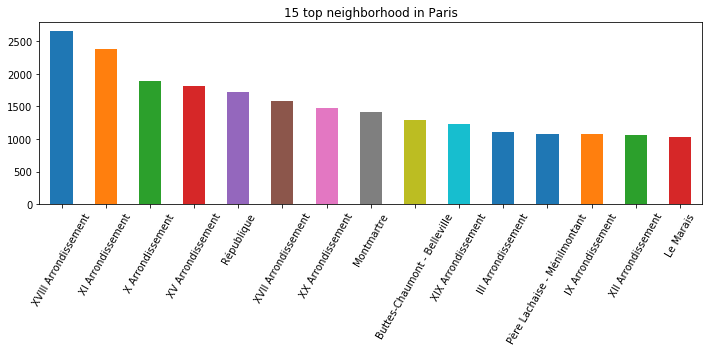

In [240]:
plt.figure(figsize=(10, 5))
df.neighbourhood.value_counts().head(15).plot(kind='bar')
plt.title('15 top neighborhood in Paris')

plt.xticks(rotation=60)
plt.subplots_adjust(bottom=0.15)
plt.tight_layout(h_pad=1.0)
plt.show()

#### Top Property Types

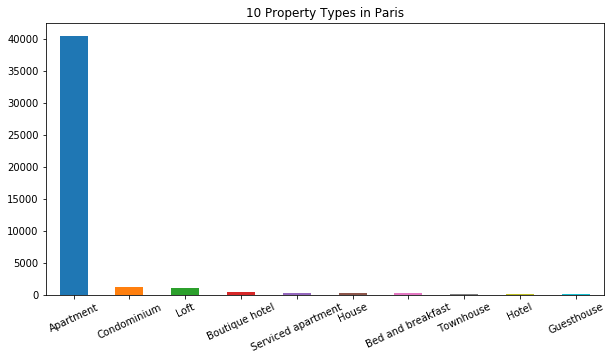

In [11]:
plt.figure(figsize=(10, 5))
df.property_type.value_counts().head(10).plot(kind='bar')

plt.xticks(rotation=25)
plt.title('10 Property Types in Paris')
plt.show()

In [12]:
df.groupby(by='room_type').count().sort_values(by='id', ascending=False)

,id,name,description,host_is_superhost,neighbourhood,property_type,number_of_reviews,review_scores_rating,reviews_per_month
room_type,,,,,,,,,
Entire home/apt,39013,39013,39013,39013,39013,39013,39013,39013,39013
Private room,5420,5420,5420,5420,5420,5420,5420,5420,5420
Shared room,325,325,325,325,325,325,325,325,325


## Prepare the data

In [13]:
# Choose top 3 property types.
top_properties = ['Apartment','Condominium','Loft']
df=df[df.property_type.isin(top_properties)]

In [14]:
neighbourhood = pd.get_dummies (df.neighbourhood)
property_type = pd.get_dummies(df.property_type)
room_type = pd.get_dummies(df.room_type)

In [15]:
categories = ['neighbourhood', 'property_type', 'room_type']
df=df.drop(columns=categories)

In [16]:
df=pd.concat([df, neighbourhood, property_type, room_type],axis=1)

In [17]:
df.head(2)

,id,name,description,host_is_superhost,number_of_reviews,review_scores_rating,reviews_per_month,Alésia,Austerlitz,Auteuil,...,XVI Arrondissement,XVII Arrondissement,XVIII Arrondissement,XX Arrondissement,Apartment,Condominium,Loft,Entire home/apt,Private room,Shared room
0,3109,zen and calm,I bedroom appartment in Paris 14 Good restaura...,0,8,100.0,0.28,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1,5396,Explore the heart of old Paris,"Cozy, well-appointed and graciously designed s...",0,173,91.0,1.44,0,0,0,...,0,0,0,0,1,0,0,1,0,0


# Cluster what the Airbnb listings are like in Paris.

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [19]:
scores=df.iloc[:, 3:]

In [20]:
super_host=df[df['host_is_superhost']==1]
super_host=super_host.iloc[:,4:]

In [21]:
super_host.head(2)

,number_of_reviews,review_scores_rating,reviews_per_month,Alésia,Austerlitz,Auteuil,Bastille,Batignolles,Bercy,Buttes-Chaumont - Belleville,...,XVI Arrondissement,XVII Arrondissement,XVIII Arrondissement,XX Arrondissement,Apartment,Condominium,Loft,Entire home/apt,Private room,Shared room
5,17,99.0,0.23,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
6,42,96.0,0.37,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


## K-Means Clustering

### function to find the optimal k

In [21]:
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)

def find_k (table):
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(table)
        kmeanModel.fit(table)
        distortions.append(sum(np.min(cdist(table, 
            kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / table.shape[0])
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

### From the entire population

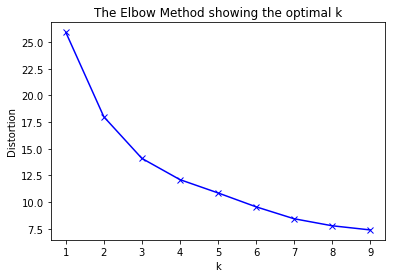

In [22]:
find_k(scores)

In [22]:
X_norm = normalize(scores)
km = KMeans(n_clusters=3)
km_pred = km.fit_predict(X_norm)

print(metrics.silhouette_score(X_norm, km.labels_, metric='euclidean'))

0.6639093161362085


In [23]:
scores['km_pred']=km_pred
scores.groupby(by='km_pred').mean()

,host_is_superhost,number_of_reviews,review_scores_rating,reviews_per_month,Alésia,Austerlitz,Auteuil,Bastille,Batignolles,Bercy,...,XVI Arrondissement,XVII Arrondissement,XVIII Arrondissement,XX Arrondissement,Apartment,Condominium,Loft,Entire home/apt,Private room,Shared room
km_pred,,,,,,,,,,,,,,,,,,,,,
0,0.305117,38.857417,93.417719,1.678266,0.018598,0.001127,0.007101,0.024008,0.016682,0.000225,...,0.021754,0.032800,0.054892,0.024910,0.937782,0.030884,0.031335,0.891682,0.098399,0.009919
1,0.332958,134.331831,92.787042,3.145487,0.012113,0.000282,0.005915,0.024507,0.011549,0.000000,...,0.024225,0.020563,0.047042,0.014366,0.927887,0.027324,0.044789,0.836338,0.155211,0.008451
2,0.080818,7.417026,92.840834,0.722551,0.018205,0.000658,0.007637,0.023143,0.021101,0.000296,...,0.022320,0.037528,0.063667,0.037199,0.950719,0.029990,0.019291,0.897554,0.096883,0.005563


In [24]:
scores.groupby(by='km_pred').count()

,host_is_superhost,number_of_reviews,review_scores_rating,reviews_per_month,Alésia,Austerlitz,Auteuil,Bastille,Batignolles,Bercy,...,XVI Arrondissement,XVII Arrondissement,XVIII Arrondissement,XX Arrondissement,Apartment,Condominium,Loft,Entire home/apt,Private room,Shared room
km_pred,,,,,,,,,,,,,,,,,,,,,
0,8872,8872,8872,8872,8872,8872,8872,8872,8872,8872,...,8872,8872,8872,8872,8872,8872,8872,8872,8872,8872
1,3550,3550,3550,3550,3550,3550,3550,3550,3550,3550,...,3550,3550,3550,3550,3550,3550,3550,3550,3550,3550
2,30377,30377,30377,30377,30377,30377,30377,30377,30377,30377,...,30377,30377,30377,30377,30377,30377,30377,30377,30377,30377


We see that the K-means divided the hosts based on the `number_of_reviews` and `reviews_per_month`.

### See Super-hosts

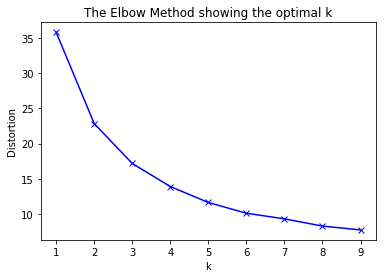

In [25]:
distortions = []

find_k(super_host)

In [25]:
X_norm = normalize(super_host)
km = KMeans(n_clusters=3)
km_pred_sh = km.fit_predict(super_host)

print(metrics.silhouette_score(X_norm, km.labels_, metric='euclidean'))

0.5922786145076747


In [26]:
super_host.shape

(6344, 72)

## Mean Shift

In [27]:
bandwidth = estimate_bandwidth(super_host, quantile=0.6, 
                               n_samples=100)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(super_host)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
print(metrics.silhouette_score(super_host, labels, metric='euclidean'))

Number of estimated clusters: 4
0.8120609336086226


In [28]:
super_host['ms_score']=labels
super_host['km_pred'] = km_pred_sh

In [30]:
super_host.groupby(by='ms_score').mean()

,number_of_reviews,review_scores_rating,reviews_per_month,Alésia,Austerlitz,Auteuil,Bastille,Batignolles,Bercy,Buttes-Chaumont - Belleville,...,XVII Arrondissement,XVIII Arrondissement,XX Arrondissement,Apartment,Condominium,Loft,Entire home/apt,Private room,Shared room,km_pred
ms_score,,,,,,,,,,,,,,,,,,,,,
0,44.39361,96.933706,1.774192,0.018371,0.000639,0.007188,0.024601,0.014537,0.000319,0.026358,...,0.033546,0.050958,0.023642,0.918211,0.042492,0.039297,0.872364,0.119968,0.007668,0.436581
1,312.00000,95.987654,5.398642,0.000000,0.012346,0.000000,0.012346,0.000000,0.000000,0.000000,...,0.024691,0.061728,0.024691,0.950617,0.012346,0.037037,0.728395,0.271605,0.000000,1.000000
2,677.00000,95.500000,9.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
3,783.00000,94.000000,9.610000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000


In [31]:
super_host.groupby(by='ms_score').count()

,number_of_reviews,review_scores_rating,reviews_per_month,Alésia,Austerlitz,Auteuil,Bastille,Batignolles,Bercy,Buttes-Chaumont - Belleville,...,XVII Arrondissement,XVIII Arrondissement,XX Arrondissement,Apartment,Condominium,Loft,Entire home/apt,Private room,Shared room,km_pred
ms_score,,,,,,,,,,,,,,,,,,,,,
0,6260,6260,6260,6260,6260,6260,6260,6260,6260,6260,...,6260,6260,6260,6260,6260,6260,6260,6260,6260,6260
1,81,81,81,81,81,81,81,81,81,81,...,81,81,81,81,81,81,81,81,81,81
2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1



- It seems like the `review_scores_rating` isn't significant when it comes to superhost clustering. However, there is a clear distinction in `number_of_reviews` and `reviews_per_month` among clusters.


Text(0.5, 1.0, 'Superhost Clusters')

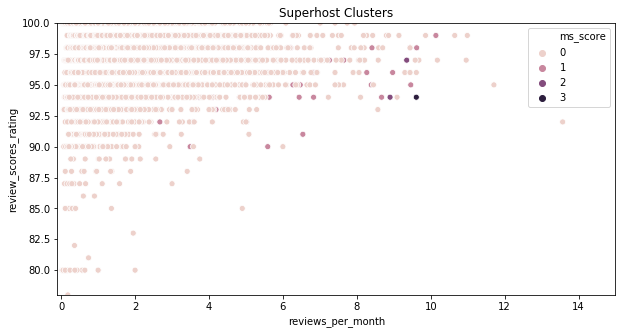

In [32]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='reviews_per_month', y='review_scores_rating', 
                hue='ms_score', data=super_host)
plt.ylim(78, 100)
plt.xlim(-0.1, 15)
plt.title('Superhost Clusters')

## Final Cluster 

What really differentiates superhosts from the other is the `number_of_reviews` and `reviews_per_month`. However, there are power hosts that aren't classified as "Superhosts", but still show the high numbers of reviews. Therefore I will be grouping the hosts in four main segments:

1. Superhost with 4 or more `reviews_per_month` 
2. Superhost with less than 4 `reviews_per_month`
3. Non-superhost more than 3 `reviews_per_month`
4. the rest who can do better...

In [33]:
# Create a final cluster column. 
df['host_cluster']=0

In [34]:
df['host_cluster'].loc[(df['host_is_superhost']==1) & (df['reviews_per_month']>=4)]=3
df['host_cluster'].loc[(df['host_is_superhost']==1) & (df['host_cluster']==0)]=2
df['host_cluster'].loc[(df['host_is_superhost']==0) & (df['reviews_per_month']>3) &
                      (df['review_scores_rating']>80)]=1

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [35]:
df.groupby(by='host_cluster').count()

,id,name,description,host_is_superhost,number_of_reviews,review_scores_rating,reviews_per_month,Alésia,Austerlitz,Auteuil,...,XVI Arrondissement,XVII Arrondissement,XVIII Arrondissement,XX Arrondissement,Apartment,Condominium,Loft,Entire home/apt,Private room,Shared room
host_cluster,,,,,,,,,,,,,,,,,,,,,
0,33805,33805,33805,33805,33805,33805,33805,33805,33805,33805,...,33805,33805,33805,33805,33805,33805,33805,33805,33805,33805
1,2650,2650,2650,2650,2650,2650,2650,2650,2650,2650,...,2650,2650,2650,2650,2650,2650,2650,2650,2650,2650
2,5802,5802,5802,5802,5802,5802,5802,5802,5802,5802,...,5802,5802,5802,5802,5802,5802,5802,5802,5802,5802
3,542,542,542,542,542,542,542,542,542,542,...,542,542,542,542,542,542,542,542,542,542


In [36]:
df.groupby(by='host_cluster').mean()

,id,host_is_superhost,number_of_reviews,review_scores_rating,reviews_per_month,Alésia,Austerlitz,Auteuil,Bastille,Batignolles,...,XVI Arrondissement,XVII Arrondissement,XVIII Arrondissement,XX Arrondissement,Apartment,Condominium,Loft,Entire home/apt,Private room,Shared room
host_cluster,,,,,,,,,,,,,,,,,,,,,
0,1.643376e+07,0.0,15.582369,92.281822,0.723242,0.017690,0.000651,0.007514,0.023014,0.020855,...,0.021831,0.036415,0.063038,0.035616,0.951664,0.027511,0.020825,0.898772,0.095252,0.005975
1,2.232492e+07,0.0,81.076604,92.064151,4.522343,0.018113,0.001509,0.006415,0.026415,0.012830,...,0.026038,0.023019,0.050189,0.018113,0.941509,0.032075,0.026415,0.846038,0.140000,0.013962
2,1.498354e+07,1.0,41.951051,96.919511,1.478735,0.018442,0.000689,0.007411,0.024647,0.014133,...,0.023268,0.033264,0.051534,0.024474,0.920200,0.040848,0.038952,0.879352,0.114443,0.006205
3,2.070982e+07,1.0,114.230627,96.933579,5.520240,0.014760,0.001845,0.003690,0.022140,0.016605,...,0.027675,0.035055,0.046125,0.014760,0.902214,0.055351,0.042435,0.771218,0.206642,0.022140


In [49]:
df.reviews_per_month.describe()

count    42799.000000
mean         1.121638
std          1.344862
min          0.000000
25%          0.230000
50%          0.630000
75%          1.500000
max         23.080000
Name: reviews_per_month, dtype: float64

In [50]:
df.review_scores_rating.describe()

count    42799.000000
mean        92.955957
std          8.216463
min         20.000000
25%         90.000000
50%         95.000000
75%         99.000000
max        100.000000
Name: review_scores_rating, dtype: float64

### Final Clusters Visualization

Text(0.5, 1.0, 'Airbnb Hosts in Paris Clusters')

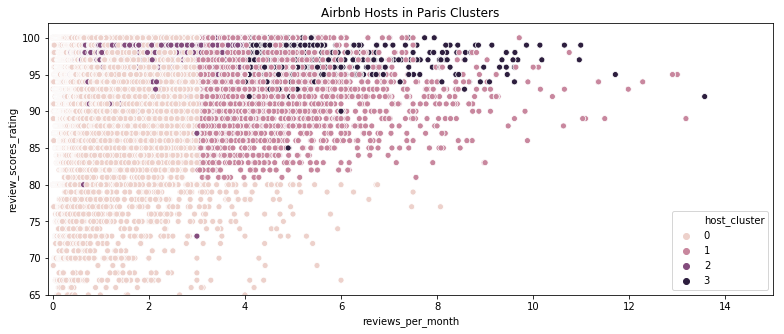

In [37]:
plt.figure(figsize=(13, 5))
sns.scatterplot(x='reviews_per_month', y='review_scores_rating', 
                hue='host_cluster', data=df)

plt.ylim(65, 102)
plt.xlim(-0.1, 15)
plt.title('Airbnb Hosts in Paris Clusters')

Superhosts definitely tend to have hight reviews and scores. However, there are some outliers with fallen scores and reviews per month.

# Analyze the text in description

## Explore and clean up the text

In [38]:
import re
import nltk
import spacy

In [39]:
df['description']=df['description'].str.lower()
df['description']=df['description'].map(lambda x: re.sub(r'[\[].,*\&?!\@\"-[\]]', '', x))
df['description']=df['description'].str.replace(r'[^0-9a-zA-Z]', ' ')

In [40]:
df['description'].head(10)
# when I run vectorizer, it will seprate french/english
# doc_frequency can be smaller due to having two languages

0     i bedroom appartment in paris 14 good restaura...
1     cozy  well appointed and graciously designed s...
2     very convenient  with the best location   plea...
3     really nice flat located in the 20th district ...
5     make your stay in paris a perfect experience  ...
6     long term rental available  the studio is situ...
7     long term rental 12 months    9 months for stu...
8     very close to place de la concorde and madelei...
9     description the apartment is located in the we...
10    num ro d enregistrement ville de paris  phone ...
Name: description, dtype: object

## CountVectorizer
- Find the most frequent words

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer(max_df=0.70,stop_words='english', max_features=10000)
word_count_vector=cv.fit_transform(df['description'])

In [42]:
word_freqs = zip(cv.get_feature_names(), word_count_vector.sum(axis=0).tolist()[0])    
# sort from largest to smallest
print (sorted(word_freqs, key=lambda x: -x[1])[:30])

[('et', 80172), ('paris', 48077), ('la', 45273), ('apartment', 39382), ('le', 37296), ('du', 32388), ('est', 31133), ('appartement', 28701), ('une', 28692), ('avec', 28295), ('room', 27576), ('des', 25877), ('les', 24601), ('pour', 22150), ('bed', 21713), ('vous', 21550), ('dans', 21224), ('minutes', 20695), ('located', 20241), ('kitchen', 19811), ('en', 19649), ('tr', 19647), ('au', 19364), ('restaurants', 18361), ('quartier', 18079), ('place', 17305), ('living', 16962), ('flat', 16153), ('floor', 16124), ('metro', 15957)]


In [43]:
# Add more stop-words
from sklearn.feature_extraction import text

df_stop_words = text.ENGLISH_STOP_WORDS.union(["et", "paris", "la", "apartment", 
                    'le', 'du', 'est', 'appartement', 'une', 'avec', 'des', 'les',
                    'pour', 'vous', 'dans','en','tr', 'au', 'il', 'sur', 'room', 'chambre' ])

In [44]:
cv=CountVectorizer(max_df=0.70,stop_words=df_stop_words, max_features=10000)
word_count_vector=cv.fit_transform(df['description'])

word_freqs = zip(cv.get_feature_names(), word_count_vector.sum(axis=0).tolist()[0])    
# sort from largest to smallest
print (sorted(word_freqs, key=lambda x: -x[1])[:30])

[('bed', 21713), ('minutes', 20695), ('located', 20241), ('kitchen', 19811), ('restaurants', 18361), ('quartier', 18079), ('place', 17305), ('living', 16962), ('flat', 16153), ('floor', 16124), ('metro', 15957), ('tro', 15758), ('studio', 15026), ('bedroom', 14768), ('bathroom', 14065), ('double', 12984), ('situ', 12652), ('equipped', 12449), ('walk', 12184), ('rue', 12025), ('calme', 11990), ('area', 11846), ('cuisine', 11841), ('min', 11552), ('quiet', 11266), ('lit', 10800), ('machine', 10729), ('10', 10701), ('bus', 10537), ('ligne', 10537)]


In [45]:
super_host_desc = df.loc[df['host_is_superhost']==1]['description']

word_count_vector=cv.transform(super_host_desc)

word_freqs = zip(cv.get_feature_names(), word_count_vector.sum(axis=0).tolist()[0])    
# sort from largest to smallest
print (sorted(word_freqs, key=lambda x: -x[1])[:30])

[('bed', 3499), ('located', 3285), ('kitchen', 3244), ('restaurants', 3061), ('floor', 3059), ('minutes', 3023), ('place', 2938), ('living', 2770), ('flat', 2657), ('bedroom', 2554), ('quartier', 2520), ('metro', 2472), ('bathroom', 2445), ('quiet', 2226), ('studio', 2182), ('building', 2135), ('tro', 2103), ('walk', 2076), ('equipped', 2034), ('area', 2004), ('double', 2000), ('rue', 1922), ('large', 1829), ('bus', 1819), ('fully', 1805), ('calme', 1796), ('situ', 1745), ('close', 1687), ('machine', 1656), ('cuisine', 1653)]


Above you see the most commonly used words in the superhosts' descriptions. Here, you can derive more meaningful keywords such as:
- restaurants
- metro
- **quiet**
- calme
- machine (which machines?)
- located & close: convenient locations

### Bigram

In [54]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=df_stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['description'], 20)
for word, freq in common_words:
    print(word, freq)
bigram_df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

fully equipped 6591
salle bain 6418
double bed 5980
sofa bed 5217
washing machine 5017
eiffel tower 4733
equipped kitchen 4511
pi ces 4363
floor elevator 4343
id al 4183
notre dame 4178
agr able 4014
10 minutes 3959
minutes walk 3816
hidden airbnb 3209
bars restaurants 3181
restaurants bars 3181
sacr coeur 3118
champs elys 3090
tour eiffel 2916


In [63]:
sh_common_words = get_top_n_bigram(super_host_desc, 20)
for word, freq in common_words:
    print(word, freq)
bigram_df['super_host'] = sh_common_words

fully equipped 6591
salle bain 6418
double bed 5980
sofa bed 5217
washing machine 5017
eiffel tower 4733
equipped kitchen 4511
pi ces 4363
floor elevator 4343
id al 4183
notre dame 4178
agr able 4014
10 minutes 3959
minutes walk 3816
hidden airbnb 3209
bars restaurants 3181
restaurants bars 3181
sacr coeur 3118
champs elys 3090
tour eiffel 2916


### Keywords: amenity and key attractions

In [66]:
bigram_df.head(10)

,ReviewText,count,super_host
0,fully equipped,6591,"(fully equipped, 1130)"
1,salle bain,6418,"(salle bain, 853)"
2,double bed,5980,"(double bed, 848)"
3,sofa bed,5217,"(eiffel tower, 831)"
4,washing machine,5017,"(notre dame, 787)"
5,eiffel tower,4733,"(washing machine, 771)"
6,equipped kitchen,4511,"(sofa bed, 750)"
7,pi ces,4363,"(floor elevator, 686)"
8,floor elevator,4343,"(equipped kitchen, 680)"
9,id al,4183,"(pi ces, 644)"


We see that as for super-hosts, the keywords for the key attractions appear more frequently. We also see that amenities such as washing machine, elevator, and equipped kitchen are key selling points. 

## TF-idf & LSA

In [67]:
# HOLD OUT 25% of the data

X = df['description']
y = df['host_is_superhost']
X_train, X_test, y_train, y_test = train_test_split (X, y, 
                                    test_size = 0.25, random_state = 10)

In [68]:
X_train.shape

(32099,)

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.6, min_df=10, 
                             stop_words=df_stop_words, 
                             use_idf=True,
                             norm=u'l2', 
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [70]:
desc_tfidf_train=vectorizer.fit_transform(X_train)
desc_tfidf_test=vectorizer.transform(X_test)

print("Number of features: %d" % desc_tfidf_train.get_shape()[1])

Number of features: 8496


In [71]:
# Downsize features using LSA.

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(2000)
lsa = make_pipeline(svd, Normalizer(copy=False))

desc_lsa_train = lsa.fit_transform(desc_tfidf_train)
desc_lsa_test = lsa.transform(desc_tfidf_test)


variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 79.0483637492515


In [221]:
#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(desc_lsa_train,index=X_train)
for i in range(3):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Component 0:
description
nice large studio very bright and central  in a very pleasant district  10 minutes of bastille   10 minutes of republic  subway at the bottom of the building  lot of restaurants and shop 30 m2 large studio light in a very nice area  10 minutes walk from the place de la bastille and 10 minutes from the republic square  in close proximity of the  marais  and  ile saint louis   the flat  includes an entrance  a kitchen with electric hob  oven  fridge  freezer  toaster and washing machine laundry  a large bright room with a double bed and a sofa  bathroom with bath and dressing room   view of the tree lined street  very good bakery just opposite  wifi internet  the studio is located on the 4th floor in a building with elevator  the metro is at the foot of the building  metro  saint ambrose  line 9 metro  richard lenoir  line 5 many restaurants and shops are at 5 minutes walk  many nearby attractions    le marais   place des vosges is beautiful     canal saint marti

In [73]:
paras_by_component['super_host']=df['host_is_superhost']

In [ ]:
plt.figure(figsize(10,5))
sns.scatterplot(x='reviews_per_month', y='review_scores_rating', 
                hue='host_cluster', data=df)

plt.ylim(65, 102)
plt.xlim(-0.1, 15)
plt.title('Airbnb Hosts in Paris Clusters')

We see that LSA nicely separated French and English descriptions. Also, you see the similarity of the descriptions among each component. 

# NLP Modeling

- See if the models can predict whether a host is superhost by using `description`.

In [75]:
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

## Random Forest

In [76]:
desc_tfidf_train

<32099x8496 sparse matrix of type '<class 'numpy.float64'>'
	with 1937075 stored elements in Compressed Sparse Row format>

In [77]:
rfc = ensemble.RandomForestClassifier()

tfidf_rfc_train = rfc.fit(desc_tfidf_train, y_train)

print('Training set score for tf-idf:', rfc.score(desc_tfidf_train, y_train))
y_pred=rfc.predict(desc_tfidf_test)

print('\nTest set score for tf-idf:', rfc.score(desc_tfidf_test, y_test))
print('\nCrosstab for tf-idf:\n', pd.crosstab(y_test, y_pred,rownames=['True'], 
                                            colnames=['Predicted'], margins=True))


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Training set score for tf-idf: 0.9752951805352191

Test set score for tf-idf: 0.858411214953271

Crosstab for tf-idf:
 Predicted      0   1    All
True                       
0           9137  25   9162
1           1490  48   1538
All        10627  73  10700


In [78]:
print('Type 1 Error:')
print(29/9162)

print('\nType 2 Error:')
print(1492/1538)

Type 1 Error:
0.0031652477624972714

Type 2 Error:
0.9700910273081924


In [79]:
lsa_rfc_train = rfc.fit(desc_lsa_train, y_train)

print('Training set score for tf-idf:', rfc.score(desc_lsa_train, y_train))
print('\nTest set score for lsa:', rfc.score(desc_lsa_test, y_test))

y_pred=rfc.predict(desc_lsa_test)
print('\nCrosstab for lsa:\n', pd.crosstab(y_test, y_pred,rownames=['True'], 
                                            colnames=['Predicted'], margins=True))

Training set score for tf-idf: 0.9757936384311038

Test set score for lsa: 0.8544859813084112

Crosstab for lsa:
 Predicted      0   1    All
True                       
0           9113  49   9162
1           1508  30   1538
All        10621  79  10700


## Logistic Regression

In [80]:
lr = LogisticRegression(C=1)

tfidf_lr_train = lr.fit(desc_tfidf_train, y_train)

print('Training set score for tf-idf:', lr.score(desc_tfidf_train, y_train))
print('\nTest set score for lsa:', lr.score(desc_tfidf_test, y_test))

y_pred=lr.predict(desc_tfidf_test)
print('\nCrosstab for tf-idf:\n', pd.crosstab(y_test, y_pred,rownames=['True'], 
                                            colnames=['Predicted'], margins=True))


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Training set score for tf-idf: 0.8551668276270289

Test set score for lsa: 0.855981308411215

Crosstab for tf-idf:
 Predicted      0   1    All
True                       
0           9139  23   9162
1           1518  20   1538
All        10657  43  10700


In [81]:
lsa_lr_train = lr.fit(desc_lsa_train, y_train)

print('Training set score for tf-idf:', lr.score(desc_lsa_train, y_train))
print('\nTest set score for lsa:', lr.score(desc_lsa_test, y_test))

y_pred=lr.predict(desc_lsa_test)
print('\nCrosstab for lsa:\n', pd.crosstab(y_test, y_pred,rownames=['True'], 
                                            colnames=['Predicted'], margins=True))

Training set score for tf-idf: 0.8539518365058102

Test set score for lsa: 0.8554205607476636

Crosstab for lsa:
 Predicted      0   1    All
True                       
0           9115  47   9162
1           1500  38   1538
All        10615  85  10700


## Gradient Descent

In [82]:
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)

tfidf_clf_train = clf.fit(desc_tfidf_train, y_train)

print('Training set score for tf-idf:', clf.score(desc_tfidf_train, y_train))
print('\nTest set score for lsa:', clf.score(desc_tfidf_test, y_test))

y_pred=clf.predict(desc_tfidf_test)
print('\nCrosstab for tf-idf:\n', pd.crosstab(y_test, y_pred,rownames=['True'], 
                                            colnames=['Predicted'], margins=True))

Training set score for tf-idf: 0.8502757095236612

Test set score for lsa: 0.8562616822429907

Crosstab for tf-idf:
 Predicted      0    All
True                   
0           9162   9162
1           1538   1538
All        10700  10700


In [83]:
lsa_clf_train = clf.fit(desc_lsa_train, y_train)

print('Training set score for tf-idf:', clf.score(desc_lsa_train, y_train))
print('\nTest set score for lsa:', clf.score(desc_lsa_test, y_test))

y_pred=clf.predict(desc_lsa_test)
print('\nCrosstab for lsa:\n', pd.crosstab(y_test, y_pred, rownames=['True'], 
                                            colnames=['Predicted'], margins=True))

Training set score for tf-idf: 0.8502757095236612

Test set score for lsa: 0.8562616822429907

Crosstab for lsa:
 Predicted      0    All
True                   
0           9162   9162
1           1538   1538
All        10700  10700


# More Feature Engineering - *Improve Models*

## Add more features

In [154]:
tfidf_train_df = pd.DataFrame(desc_tfidf_train.toarray(), 
                              columns=vectorizer.get_feature_names())
tfidf_test_df = pd.DataFrame(desc_tfidf_test.toarray(), 
                              columns=vectorizer.get_feature_names())

In [155]:
tfidf_train_df.head()

,00,000,00am,00pm,02,05,08,09,10,100,...,zara,zen,zenith,zero,zinc,zola,zona,zone,zones,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049578,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049516,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169690,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
tfidf_train_df.shape

(32099, 8496)

In [156]:
# try without LSA
X_train_feature = pd.concat([neighbourhood, tfidf_train_df], 
                            axis=1, join_axes=[X_train.index])
X_test_feature = pd.concat([neighbourhood, tfidf_test_df], 
                           axis=1, join_axes=[X_test.index])

feature_set = pd.concat([X_train_feature, X_test_feature]).fillna(0)

In [157]:
feature_set['host_cluster']=df.host_cluster
feature_set['super_host']=df.host_is_superhost

In [116]:
feature_set.head(2)

,Alésia,Austerlitz,Auteuil,Bastille,Batignolles,Bercy,Buttes-Chaumont - Belleville,Canal Saint-Martin,Champs-Elysées,Châtelet - Les Halles - Beaubourg,...,zenith,zero,zinc,zola,zona,zone,zones,zoo,host_cluster,super_host
36623,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1
35621,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [106]:
feature_set.shape

(42799, 8561)

In [117]:
feature_set.shape

(42799, 8561)

## Balance Training Set

### Smaller training set (2000x2000)

In [160]:
# I have an imbalanced dataset. I will be balancing the training set. 
train_set_sm = pd.concat([feature_set.loc[feature_set.super_host==1][:2000], 
                         feature_set.loc[feature_set.super_host==0][:2000]])
test_set_sm = pd.concat([feature_set.loc[feature_set.super_host==1][2000:], 
                        feature_set.loc[feature_set.super_host==0][2000:]])

In [161]:
train_set.shape

(4000, 8561)

In [162]:
train_set.head()

,Alésia,Austerlitz,Auteuil,Bastille,Batignolles,Bercy,Buttes-Chaumont - Belleville,Canal Saint-Martin,Champs-Elysées,Châtelet - Les Halles - Beaubourg,...,zenith,zero,zinc,zola,zona,zone,zones,zoo,host_cluster,super_host
36623,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1
40228,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1
32410,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1
25919,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1
52187,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1


In [163]:
X_train2 = train_set_sm.iloc[:,:8559]
y_train2 = train_set_sm['host_cluster']
y_train_sh = train_set_sm['super_host']

X_test2 = test_set_sm.iloc[:,:8559]
y_test2 = test_set_sm['host_cluster']
y_test_sh = test_set_sm['super_host']


In [164]:
X_train2.shape

(4000, 8559)

In [165]:
X_test2.shape

(38799, 8559)

In [166]:
X_train2.head(2)

,Alésia,Austerlitz,Auteuil,Bastille,Batignolles,Bercy,Buttes-Chaumont - Belleville,Canal Saint-Martin,Champs-Elysées,Châtelet - Les Halles - Beaubourg,...,zara,zen,zenith,zero,zinc,zola,zona,zone,zones,zoo
36623,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40228,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Predict Superhost

In [168]:
lsa_rfc_train = rfc.fit(X_train2, y_train_sh)

print('Training set score:', rfc.score(X_train2, y_train_sh))
print('\nTest set score:', rfc.score(X_test2, y_test_sh))

y_pred=rfc.predict(X_test2)
y_pred_train=rfc.predict(X_train2)

print('\nCrosstab for traing set:\n', pd.crosstab(y_train_sh, y_pred_train, rownames=['True'], 
                                            colnames=['Predicted'], margins=True))
print('\nCrosstab for test set:\n', pd.crosstab(y_test_sh, y_pred,rownames=['True'], 
                                            colnames=['Predicted'], margins=True))

Training set score: 0.80925

Test set score: 0.5696023093378695

Crosstab for traing set:
 Predicted     0     1   All
True                       
0          1704   296  2000
1           467  1533  2000
All        2171  1829  4000

Crosstab for test set:
 Predicted      0      1    All
True                          
0          20279  14176  34455
1           2523   1821   4344
All        22802  15997  38799


In [132]:
print('Type 1 Error:')
print(15382/34455)

print('\nType 2 Error:')
print(2345/4344)

Type 1 Error:
0.44643738209258454

Type 2 Error:
0.5398250460405156


### Predict Clusters - Small Training Set Score

In [169]:
#training set 2000x2000
lsa_rfc_train = rfc.fit(X_train2, y_train2)

print('Training set score:', rfc.score(X_train2, y_train2))
print('\nTest set score:', rfc.score(X_test2, y_test2))

y_pred=rfc.predict(X_test2)
y_pred_train=rfc.predict(X_train2)

print('\nCrosstab for traing set:\n', pd.crosstab(y_train2, y_pred_train,rownames=['True'], 
                                            colnames=['Predicted'], margins=True))
print('\nCrosstab for test set:\n', pd.crosstab(y_test2, y_pred,rownames=['True'], 
                                            colnames=['Predicted'], margins=True))

Training set score: 0.78125

Test set score: 0.5173071470914199

Crosstab for traing set:
 Predicted     0   1     2   3   All
True                               
0          1575   1   277   0  1853
1            62  43    42   0   147
2           390   1  1452   0  1843
3            56   0    46  55   157
All        2083  45  1817  55  4000

Crosstab for test set:
 Predicted      0   1      2  3    All
True                                 
0          18390  52  13509  1  31952
1           1417   5   1080  1   2503
2           2277   6   1676  0   3959
3            206   0    179  0    385
All        22290  63  16444  2  38799


###  Larger training set (4000x4000)

In [170]:
train_set_lg = pd.concat([feature_set.loc[df.host_is_superhost==1][:4000], 
                         feature_set.loc[df.host_is_superhost==0][:4000]])
test_set_lg = pd.concat([feature_set.loc[df.host_is_superhost==1][4000:], 
                        feature_set.loc[df.host_is_superhost==0][4000:]])

X_train2 = train_set_lg.iloc[:,:8559]
y_train2 = train_set_lg['host_cluster']

X_test2 = test_set_lg.iloc[:,:8559]
y_test2 = test_set_lg['host_cluster']

print(X_train2.shape)
print(X_test2.shape)

(8000, 8559)
(34799, 8559)


In [137]:
# rfc with a training set 4000x4000
lsa_rfc_train = rfc.fit(X_train2, y_train2)

print('Training set score:', rfc.score(X_train2, y_train2))
print('\nTest set score:', rfc.score(X_test2, y_test2))

y_pred=rfc.predict(X_test2)
y_pred_train=rfc.predict(X_train2)

print('\nCrosstab for traing set:\n', pd.crosstab(y_train2, y_pred_train,rownames=['True'], 
                                            colnames=['Predicted'], margins=True))
print('\nCrosstab for test set:\n', pd.crosstab(y_test2, y_pred,rownames=['True'], 
                                            colnames=['Predicted'], margins=True))

Training set score: 0.77575

Test set score: 0.5187218023506422

Crosstab for traing set:
 Predicted     0   1     2    3   All
True                                
0          3131   0   589    1  3721
1           120  79    80    0   279
2           785   0  2878    0  3663
3           115   0   104  118   337
All        4151  79  3651  119  8000

Crosstab for test set:
 Predicted      0  1      2   3    All
True                                 
0          17127  2  12934  21  30084
1           1288  1   1075   7   2371
2           1215  1    922   1   2139
3            103  0    101   1    205
All        19733  4  15032  30  34799


##  Add LSA to a training set (4000x4000)

In [146]:
X_train_feature_lsa =  pd.DataFrame(desc_lsa_train)
X_test_feature_lsa = pd.DataFrame(desc_lsa_test)


X_train_feature = pd.concat([X_train_feature, X_train_feature_lsa], 
                            axis=1, join_axes=[X_train.index])
X_test_feature = pd.concat([X_test_feature, X_test_feature_lsa], 
                           axis=1, join_axes=[X_test.index])

feature_set = pd.concat([X_train_feature, X_test_feature]).fillna(0)
feature_set['host_cluster']=df.host_cluster

train_set = pd.concat([feature_set.loc[df.host_is_superhost==1][:2000], 
                         feature_set.loc[df.host_is_superhost==0][:2000]])
test_set = pd.concat([feature_set.loc[df.host_is_superhost==1][2000:], 
                        feature_set.loc[df.host_is_superhost==0][2000:]])

print(train_set.shape)
print(test_set.shape)
train_set.head(3)

(4000, 12560)
(38799, 12560)


,Alésia,Austerlitz,Auteuil,Bastille,Batignolles,Bercy,Buttes-Chaumont - Belleville,Canal Saint-Martin,Champs-Elysées,Châtelet - Les Halles - Beaubourg,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,host_cluster
36623,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
40228,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
32410,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [148]:
X_train3 = train_set.iloc[:,:12559]
y_train3 = train_set['host_cluster']

X_test3 = test_set.iloc[:,:12559]
y_test3 = test_set['host_cluster']

print(X_train3.shape)
print(X_test3.shape)

(4000, 12559)
(38799, 12559)


In [149]:
X_train2.head(2)

,Alésia,Austerlitz,Auteuil,Bastille,Batignolles,Bercy,Buttes-Chaumont - Belleville,Canal Saint-Martin,Champs-Elysées,Châtelet - Les Halles - Beaubourg,...,zara,zen,zenith,zero,zinc,zola,zona,zone,zones,zoo
36623,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40228,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
lsa_rfc_train = rfc.fit(X_train3, y_train3)

print('Training set score:', rfc.score(X_train3, y_train3))
print('\nTest set score:', rfc.score(X_test3, y_test3))

y_pred=rfc.predict(X_test3)
y_pred_train=rfc.predict(X_train3)

print('\nCrosstab for traing set:\n', pd.crosstab(y_train3, y_pred_train,rownames=['True'], 
                                            colnames=['Predicted'], margins=True))
print('\nCrosstab for test set:\n', pd.crosstab(y_test3, y_pred,rownames=['True'], 
                                            colnames=['Predicted'], margins=True))

Training set score: 0.78225

Test set score: 0.49240959818552027

Crosstab for traing set:
 Predicted     0   1     2   3   All
True                               
0          1531   0   322   0  1853
1            61  42    44   0   147
2           347   0  1496   0  1843
3            59   0    38  60   157
All        1998  42  1900  60  4000

Crosstab for test set:
 Predicted      0  1      2  3    All
True                                
0          17280  4  14665  3  31952
1           1327  0   1175  1   2503
2           2133  1   1825  0   3959
3            202  0    183  0    385
All        20942  5  17848  4  38799


It seems like it's tough to predict host clusters with current dataset. It's interesting that adding LSA dropped the testing score. The best model seems to be the random forest using tf-idf and neighborhood as features.

# Does the discription determine the quality of listing?

In [181]:
X_train2 = train_set_sm.iloc[:,:8559]
X_test2 = test_set_sm.iloc[:,:8559]

y_train2 = train_set_sm['host_cluster']
y_test2 = test_set_sm['host_cluster']

rfc_train_cluster = rfc.fit (X_train2, y_train2)
rfc_ypred_cluster=rfc.predict(X_test2)
y_pred_train=rfc.predict(X_train2)

print('Training set score:', rfc.score(X_train2, y_train2))
print('\nTest set score:', rfc.score(X_test2, y_test2))

print('\nCrosstab:\n', pd.crosstab(y_test2, rfc_ypred_cluster, rownames=['True'], 
                                            colnames=['Predicted'], margins=True))


Training set score: 0.7835

Test set score: 0.5293177659218021

Crosstab:
 Predicted      0  1      2  3    All
True                                
0          18893  4  13053  2  31952
1           1454  0   1049  0   2503
2           2314  1   1644  0   3959
3            222  0    163  0    385
All        22883  5  15909  2  38799


In [182]:
X_test2['rfc_predict']=rfc_ypred_cluster
X_test2['final_cluster']=df['host_cluster']

In [183]:
X_test2['reviews_per_month']=df['reviews_per_month']
X_test2['review_scores_rating']=df['review_scores_rating']

In [187]:
X_test2.groupby(by='rfc_predict')[['reviews_per_month', 'final_cluster','review_scores_rating']].mean()

,reviews_per_month,final_cluster,review_scores_rating
rfc_predict,,,
0,1.091028,0.294891,92.815758
1,0.400000,0.400000,94.400000
2,1.094187,0.303350,92.732353
3,0.060000,0.000000,86.000000


In [200]:
X_test2.groupby(by='rfc_predict')['reviews_per_month'].count()

rfc_predict
0    22883
1        5
2    15909
3        2
Name: reviews_per_month, dtype: int64

In [195]:
import plotly.graph_objs as go
import plotly.plotly as py
plotly.tools.set_credentials_file(username='JinnyK', api_key='yuG6wYSbbPkHWB2voTbJ')

In [205]:
cluster0=X_test2.loc[X_test2['rfc_predict']==0]
cluster2=X_test2.loc[X_test2['rfc_predict']==2]

In [208]:
trace0 = go.Scatter(
    y = cluster0['review_scores_rating'],
    x = cluster0['reviews_per_month'],
    name = 'Cluster 0',
    mode = 'markers',
    opacity=0.5,
    marker = dict(
        size = 10,
        color = 70,
        opacity=0.5,
        line = dict(
            width = 2,
            color = 'rgb(0, 0, 0)'
        )
    )
)

trace1 = go.Scatter(
    y = cluster2['review_scores_rating'],
    x = cluster2['reviews_per_month'],
    name = 'Cluster 2',
    mode = 'markers',
    opacity=0.5,
    marker = dict(
        size = 10,
        color = 'rgb(231, 99, 250)',
        opacity=0.5,
        line = dict(
            width = 2,
            color = 'rgb(0, 0, 0)'
        )
    )
)

data = [trace0, trace1]

py.iplot(data, filename='Airbnb Cluster')

The draw time for this plot will be slow for clients without much RAM.


/anaconda3/lib/python3.7/site-packages/chart_studio/api/v1/clientresp.py:44: UserWarning:

Estimated Draw Time Slow

/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



# Conclusion

Airbnb offers great datasets about the city's available stays. Predicting the listing's quality and performance with the descriptions alone is challenging as we see the result above.

In the future, I would like to do the followings to improve my model:
- Combine with different datasets such as price, calendar, etc.
- Train NLP models with larger corpus.
- Use word2vec, spacy or tensor flow.